# BigARTM new Python API.

## Example #1

This paper provides simple example of usage of new Python API. We will learn a model on the small dataset 'kos'.
Let's make necessary imports at first (note that you should have artm_model.py path in your Pyhton PATH variable):

In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt

import artm.artm_model
from artm.artm_model import *

The first step is to create a topic model. New API allows us to do it as a single line:

In [2]:
model = ArtmModel(num_processors=2, topics_count = 15, document_passes_count=1)

ArtmModel is an object, that contains all information about current state of the topic model. All our next actions will be held over it. First of all we need to parse the collection from 'docword' and 'vocab' files in UCI format, if it is necessary:

In [3]:
if len(glob.glob('kos' + "/*.batch")) < 1:
    model.parse(data_path='', data_format='bow_uci', collection_name='kos')

Next step is to initilize model with collection dictionary. It means, that 
- Phi matrix 'pwt' will be created in appliance with number of tokens in dictionary and topics count in model
- This matrix will be filled with random numbers in (0, 1) and normalized

In [4]:
model.initialize(dictionary=model.load_dictionary('kos/dictionary'))

ArtmModel provides all model scores, that exists in BigARTM. If you have applied the score to the model, the model will save it's values on every update of Phi matrix.
In order to control the quality of the model we will add come scores to it:

In [5]:
model.scores.add(SparsityPhiScore(name='SparsityPhiScore'))
model.scores.add(SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(PerplexityScore(name='PerplexityScore'))

Also it is usefull to add basic regularizers to improve sparsity and variance of the topics (we will set some initial tau coeffitients for the regularizers, they can be changed in future)

In [6]:
model.regularizers.add(SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(SmoothSparseThetaRegularizer(name='SparseTheta', tau=-2.0))
model.regularizers.add(DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=100000.0))

Now let's try to learn the model in the offline mode (e.g. with one Phi update during one scan of the whole collection). We will invoke 5 scans:

In [7]:
model.fit_offline(data_path='kos', collection_passes_count=5)

fit_offline() found 4 batches


Let's check the result of the first iteration of learning:

In [8]:
print 'Sparsity Phi:' + str(model.scores_info['SparsityPhiScore'].value[model.num_phi_updates-1])
print 'Sparsity Theta:' + str(model.scores_info['SparsityThetaScore'].value[model.num_phi_updates-1])

Sparsity Phi:0.269446857805
Sparsity Theta:0.0504412050534


We can see, that sparsity levels of both Phi and Theta are too low. Let's increase (in modulus) the coefficients of regularization for sparsity regularizers:

In [9]:
model.regularizers['SparsePhi'].tau = -0.4
model.regularizers['SparseTheta'].tau = -3.0

Also it will be useful to add new score 'TopTokensScore'. It will allow us to see the most probable tokens in each topic

In [10]:
model.scores.add(TopTokensScore(name='TopTokensScore', num_tokens=5))

Next we will continue the learning of our model, 15 scans of the collection will be invoked now

In [11]:
model.fit_offline(data_path='kos', collection_passes_count=15)

fit_offline() found 4 batches


In [12]:
print 'Sparsity Phi:' + str(model.scores_info['SparsityPhiScore'].value[model.num_phi_updates-1])
print 'Sparsity Theta:' + str(model.scores_info['SparsityThetaScore'].value[model.num_phi_updates-1])

Sparsity Phi:0.465942658558
Sparsity Theta:0.126535471331


The sparsity is still unsatisfactory. Let's try new tau coefficients and continue model learning:

In [13]:
model.regularizers['SparsePhi'].tau = -1.5
model.regularizers['SparseTheta'].tau = -5.0
model.fit_offline(data_path='kos', collection_passes_count=15)

fit_offline() found 4 batches


Let's plot perplexity and sparsity of the model to check it's quality:

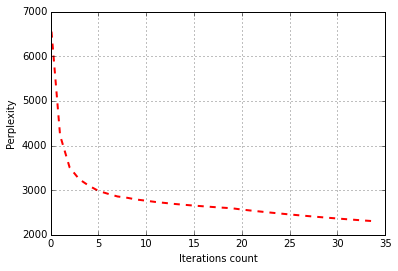

In [14]:
plt.plot(range(model.num_phi_updates), model.scores_info['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

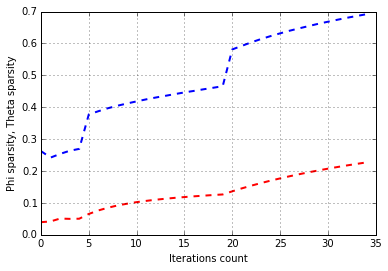

In [15]:
plt.plot(range(model.num_phi_updates), model.scores_info['SparsityPhiScore'].value, 'b--',
         range(model.num_phi_updates), model.scores_info['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Phi sparsity, Theta sparsity')
plt.grid(True)
plt.show()

For such small collection the sparsity is enough. Next step is to visualize the top tokens:

In [16]:
for topic_name in model.topic_names:
    print topic_name + ': ',
    print model.scores_info['TopTokensScore'].topic_info[model.num_phi_updates-1][topic_name].tokens

@topic_0:  [u'time', u'november', u'republicans', u'party', u'democratic']
@topic_1:  [u'primary', u'house', u'democratic', u'dean', u'edwards']
@topic_2:  [u'people', u'media', u'percent', u'voters', u'president']
@topic_3:  [u'bush', u'polls', u'poll', u'edwards', u'kerry']
@topic_4:  [u'vote', u'house', u'voters', u'kerry', u'general']
@topic_5:  [u'million', u'kerry', u'campaign', u'states', u'republicans']
@topic_6:  [u'iraq', u'war', u'president', u'bush', u'campaign']
@topic_7:  [u'republican', u'iraq', u'news', u'war', u'american']
@topic_8:  [u'race', u'political', u'media', u'senate', u'percent']
@topic_9:  [u'news', u'national', u'house', u'iraq', u'republican']
@topic_10:  [u'bush', u'kerry', u'general', u'dean', u'john']
@topic_11:  [u'state', u'republican', u'race', u'gop', u'senate']
@topic_12:  [u'november', u'electoral', u'governor', u'election', u'republicans']
@topic_13:  [u'administration', u'war', u'military', u'president', u'attacks']
@topic_14:  [u'war', u'admini

Our last step is to save the model. ArtmModel provides two opportunities: save the model in BigARTM format and in .csv. 
- in first case you won't be able to visualize the model, but it can be loaded back in library for further learning;
- .csv format could not be loaded back, but you are able to look at the Phi matrix by your eyes.

Let's use both of methods:

In [17]:
model.save(file_name='kos_artm_model')
model.to_csv(file_name='kos_artm_model.csv')

In addition we can get the Theta matrix of the collection:

In [18]:
theta_matrix = model.get_theta()

ArtmModel.get_theta() returns Theta matrix as pandas.DataFrame object. Let's print it:

In [19]:
print theta_matrix

               1         2         3         4         5         6     \
@topic_0   0.014261  0.000000  0.105319  0.019052  0.033899  0.000000   
@topic_1   0.009671  0.000000  0.112252  0.018944  0.059511  0.000000   
@topic_2   0.072351  0.000000  0.002619  0.052918  0.088838  0.130116   
@topic_3   0.050547  0.000000  0.022269  0.014338  0.091518  0.461974   
@topic_4   0.047901  0.145377  0.034588  0.066858  0.078943  0.000000   
@topic_5   0.066929  0.048521  0.008950  0.024730  0.046341  0.000000   
@topic_6   0.086723  0.176252  0.000000  0.278602  0.093366  0.000000   
@topic_7   0.154492  0.000000  0.000000  0.081138  0.070640  0.000000   
@topic_8   0.108675  0.036419  0.039579  0.189418  0.106646  0.000000   
@topic_9   0.065367  0.000000  0.000000  0.082803  0.069246  0.000000   
@topic_10  0.101369  0.593430  0.000931  0.015973  0.134315  0.150549   
@topic_11  0.057795  0.000000  0.000000  0.061220  0.053252  0.257360   
@topic_12  0.000000  0.000000  0.627942  0.022108  

## Example #2

This is a second part of paper about basic usage of new Python API of BigARTM library. We will load back the model, saved in previous example, and proceed some new operations.

The first step is to create a topic model:

In [20]:
new_model = ArtmModel(num_processors=2, topics_count = 1, document_passes_count=1)

Second step is to add regularizers and scores. We'll restrict ourselves to one new score and two regularizers:

In [21]:
new_model.scores.add(TopicKernelScore(name='TopicKernelScore'))
new_model.regularizers.add(SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
new_model.regularizers.add(DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=100000.0))

Now we will load 'kos_artm_model' file into library

In [22]:
new_model.load('kos_artm_model')

Note, that loaded model will overwrite several things in you ArtmModel object: number of topics and their names, Phi matrix. It also will reset all saved information about topic model scores values. 

Nevertheless the scores and the regularizers, applied to ArtmModel object earlier, won't change. In our case it is a 'TopicKernelScore' score and 'SparsePhi' and 'DecorrelatorPhi' regularizers.

Now let's continue model learning, but in online mode. It means that
- the number of passes through single document will increase
- Phi matrix updates will be proceed several times during one pass of the collection
- we need only one pass through the collection (but here we'll do 5, because the 'kos' collection is too small).

In [23]:
new_model.document_passes_count = 5
for i in range(5):
    new_model.fit_online(data_path='kos', update_every=4)

fit_online() found 4 batches
fit_online() found 4 batches
fit_online() found 4 batches
fit_online() found 4 batches
fit_online() found 4 batches


'update_every' tells model the number of batches to be processed before next update of Phi.

Let's visualize topic kernel scores (average contrast and purity):

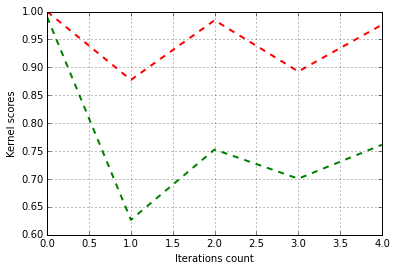

In [24]:
plt.plot(range(new_model.num_phi_updates), new_model.scores_info['TopicKernelScore'].average_contrast, 'g--',
         range(new_model.num_phi_updates), new_model.scores_info['TopicKernelScore'].average_purity, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Kernel scores')
plt.grid(True)
plt.show()

As we see, the further study of loaded model only downgraded the quality of the model.

Also we can see all information about each topic. For instance let's print topic kernel tokens for first topic:

In [25]:
print new_model.scores_info['TopicKernelScore'].topic_info[new_model.num_phi_updates-1][new_model.topic_names[0]].tokens

[u'ability', u'additional', u'ado', u'age', u'agreed', u'aksen', u'alqaeda', u'anniversary', u'appeal', u'application', u'aps', u'assembly', u'atlanta', u'attributed', u'barend', u'basis', u'beer', u'began', u'bench', u'berg', u'biggest', u'black', u'boston', u'brahimi', u'building', u'carry', u'cast', u'ceremony', u'changed', u'collapse', u'columbia', u'commissions', u'completely', u'condis', u'conflicts', u'continued', u'cycles', u'deadline', u'determine', u'discipline', u'donors', u'double', u'emilys', u'entered', u'existing', u'feels', u'feet', u'filter', u'financial', u'finished', u'floor', u'forget', u'fresh', u'fun', u'fundraisers', u'goal', u'gods', u'grand', u'graphic', u'graves', u'guild', u'guilty', u'guns', u'happen', u'happened', u'happy', u'hear', u'hearings', u'heart', u'hiring', u'hotels', u'hunt', u'inappropriate', u'indication', u'indictment', u'interest', u'invaded', u'involved', u'jokes', u'jury', u'knew', u'learned', u'longer', u'looked', u'lud', u'mcauliffe', u'me

If we have the batch with documents, that didn't take part in model learning, and we want to get Theta matrix for it, we can use 'find_theta' method:

In [26]:
test_theta_matrix = model.find_theta(data_path='kos_test', batches=['test_docs.batch'])

ArtmModel.find_theta(), as ArtmModel.get_theta(), returns Theta matrix as pandas.DataFrame object. Let's print it:

In [27]:
print test_theta_matrix

               3001      3002      3003      3004      3005      3006  \
@topic_0   0.052405  0.056842  0.067987  0.074254  0.048657  0.092068   
@topic_1   0.057474  0.065114  0.025062  0.059797  0.074546  0.084413   
@topic_2   0.074210  0.037380  0.056515  0.062600  0.049415  0.029606   
@topic_3   0.062127  0.035865  0.087573  0.056028  0.045298  0.039367   
@topic_4   0.075845  0.073009  0.114470  0.071336  0.074960  0.051759   
@topic_5   0.048106  0.042939  0.126453  0.095189  0.100056  0.034118   
@topic_6   0.096502  0.051853  0.041913  0.078791  0.074480  0.021237   
@topic_7   0.095494  0.224685  0.064006  0.073358  0.112833  0.029555   
@topic_8   0.059493  0.062609  0.035958  0.059914  0.069148  0.041933   
@topic_9   0.088458  0.064677  0.037460  0.057890  0.079724  0.029288   
@topic_10  0.055875  0.037867  0.125445  0.096637  0.099749  0.036904   
@topic_11  0.054936  0.081085  0.056414  0.077700  0.049745  0.024867   
@topic_12  0.021757  0.038342  0.043907  0.033245  